# Kickstarter Analysis

In [1]:
# Import necessary modules and functions

import pandas as pd
import seaborn as sns
import scipy.stats as ss
import numpy as np
import math
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from datetime import datetime

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the 'KS_train_data.csv' file into a Pandas DataFrame.
df = pd.read_csv('KS_train_data.csv', delimiter=',')

# Import the 'KS_test_data.csv' file into a Pandas DataFrame.
pd_test = pd.read_csv('KS_test_data.csv', delimiter=',')

## Data Preparation

Drop unrelated columns

<i>Note: <b>name</b>, <b>blurb</b> might have some correlation to <b>funded</b> status which may be found using text mining</i>

In [3]:
df = df.drop(columns=['project_id','project_url','reward_url'])

Encode the categorical columns such as <b>category</b>

In [4]:
#label_encoder = LabelEncoder()
#df.iloc[:,1] = label_encoder.fit_transform(df.iloc[:,1]).astype('float64')

## Feature Engineering

In [5]:
df['name_len'] = df['name'].str.len()

Find the duration of the project in days and add it as a column to the dataset

In [6]:
df['duration'] = (df['deadline'] - df['launched_at'])/(60*60*24)

Find launch year

In [7]:
def get_year(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.year

df['launched_year'] = df['launched_at'].apply(get_year)

Find launch month

In [8]:
def get_month(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.month

df['launched_month'] = df['launched_at'].apply(get_month)

Find launch week

In [9]:
def get_week(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.isocalendar()[1]


df['launched_week'] = df['launched_at'].apply(get_week)

Find launch day

In [10]:
def get_day(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.day

df['launched_day'] = df['launched_at'].apply(get_day)

Find launch quarter

In [11]:
def get_quarter(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    if (time_s.month > 0 and time_s.month < 4):
        return 1
    if (time_s.month > 3 and time_s.month < 7):
        return 2
    if (time_s.month > 6 and time_s.month < 10):
        return 3
    if (time_s.month > 9 and time_s.month < 13):
        return 4

df['launched_quarter'] = df['launched_at'].apply(get_quarter)

Average pledge per backer

In [12]:
df['average_pledge'] = df['usd_pledged'] / df['backers_count']

#### Creating Goal and Duration percentile buckets

Will create percentile buckets for the goal amount in a category

In [13]:
df['goal_cat_perc'] =  df.groupby(['category'])['goal'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =[1,2,3]))

Will create percentile buckets for the duration in a category

In [14]:
df['duration_cat_perc'] =  df.groupby(['category'])['duration'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =False, duplicates='drop'))

#### Calculating competitors for quarter, month and week
These functions' parameters can be updated to find a lot more possibly successful features
* Combination with **duration_cat_perc** might be very effective

Calculate competitors for the quarter

In [15]:
df['competitors_qtr'] = df.groupby(['category','launched_year','launched_quarter','goal_cat_perc'])['funded'].transform('count')

Calculate competitors for the month

In [16]:
df['competitors_month'] = df.groupby(['category','launched_year','launched_month','goal_cat_perc'])['funded'].transform('count')

Calculate competitors for the week

In [17]:
df['competitors_week'] = df.groupby(['category','launched_year','launched_week','goal_cat_perc'])['funded'].transform('count')

## Exploratory Data Analysis

In [18]:
df

,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,goal,...,launched_month,launched_week,launched_day,launched_quarter,average_pledge,goal_cat_perc,duration_cat_perc,competitors_qtr,competitors_month,competitors_week
0,80,I will be an artist-in-residence at Elsewhere ...,art,3596,US,1325980505,USD,1334866560,1.000000,2800.0,...,3,13,28,1,44.950000,2.0,0.0,236,95,24
1,82,1000 Artists is a public art-making installati...,art,4586,US,1330926084,USD,1336440145,1.000000,4500.0,...,3,13,29,1,55.926829,2.0,2.0,236,95,24
2,21,"The Sequel to ‘My Favorite Machine”, ""MyPhoneH...",art,5217,US,1332382894,USD,1338175739,1.000000,5000.0,...,3,13,29,1,248.428571,2.0,2.0,236,95,24
3,37,A film exploring the role and value of art edu...,art,7160,GB,1332342451,USD,1334806096,1.000000,6500.0,...,3,13,29,1,193.513514,3.0,0.0,151,67,17
4,153,We need to build a kitchen for Habitable Space...,art,15445,US,1328562617,USD,1335584240,1.000000,15000.0,...,3,13,29,1,100.947712,3.0,0.0,151,67,17
5,18,Source Material is 2 person exhibition of the ...,art,2190,US,1331239703,USD,1336090320,1.000000,600.0,...,3,13,29,1,121.666667,1.0,2.0,179,84,13
6,156,An anthropological field study of the Dwarven ...,art,5429,US,1332802530,USD,1334030340,1.000000,2000.0,...,3,13,29,1,34.807372,2.0,0.0,236,95,24
7,479,Portrait artist seeks funds to kickstart an ex...,art,62736,US,1331325438,USD,1335671940,1.000000,10000.0,...,3,13,27,1,130.972881,3.0,2.0,151,67,17
8,41,This is a month long Residency at the The Verm...,art,2930,US,1331904129,USD,1336736610,1.000000,2800.0,...,3,13,27,1,71.463415,2.0,2.0,236,95,24
9,25,"Art, Music, and Theater live on the Waterfront...",art,5001,US,1330979179,USD,1335443088,1.000000,5000.0,...,3,13,27,1,200.040000,2.0,0.0,236,95,24


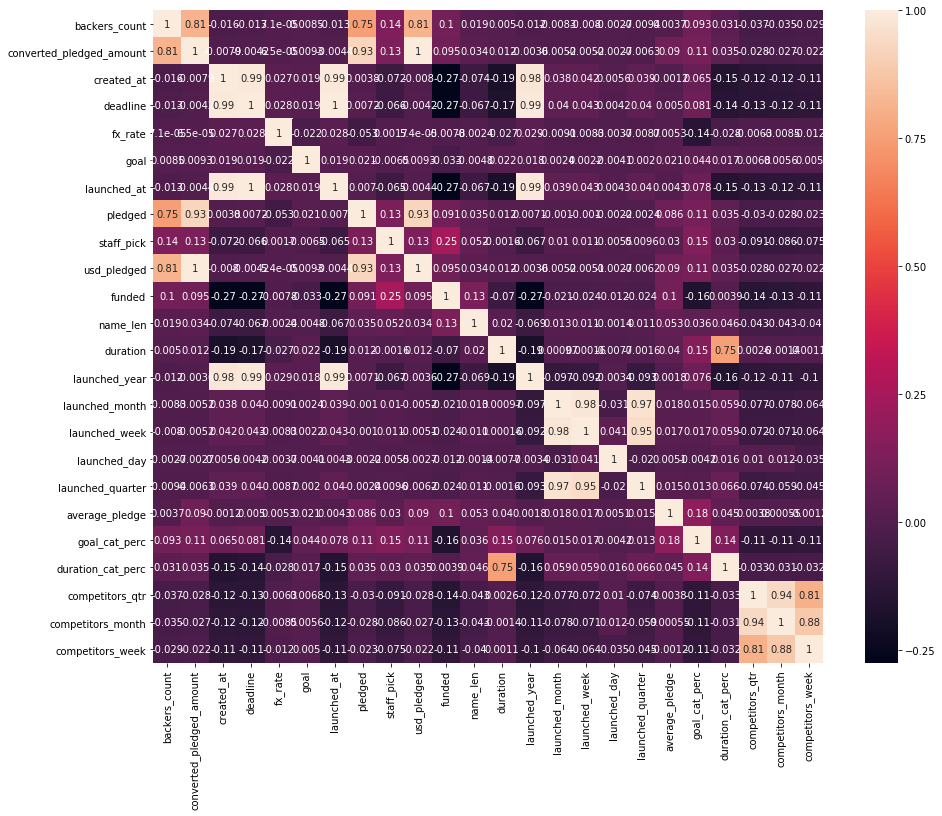

In [19]:
corr = df.corr()

f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, annot=True)